<a href="https://colab.research.google.com/github/SantonioTheFirst/DCGANime/blob/main/DCGANime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d splcher/animefacedataset
!unzip -q animefacedataset.zip

 98% 385M/395M [00:09<00:00, 46.1MB/s]
100% 395M/395M [00:09<00:00, 45.0MB/s]


In [3]:
import numpy as np
import os
from PIL import Image
import tensorflow
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Flatten, Reshape
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import pickle

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

batch_size = 128
epochs = 30
latent_dims = 100

images_path = 'images'
image_size = 64

optimizer = Adam(learning_rate=1e-4, beta_1=0.5)

model_save_path = 'model'
os.mkdir(model_save_path)

In [ ]:
assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

tpu_address = TF_MASTER

In [ ]:
resolver = tensorflow.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
tensorflow.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tensorflow.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tensorflow.config.list_logical_devices('TPU'))
print("Number of devices: ", len(tensorflow.config.list_logical_devices('TPU')))

In [ ]:
strategy = tensorflow.distribute.TPUStrategy(resolver)

In [4]:
images = os.listdir(images_path)

In [5]:
img = Image.open(os.path.join(images_path, images[0]))

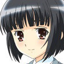

In [6]:
img.resize((64, 64))

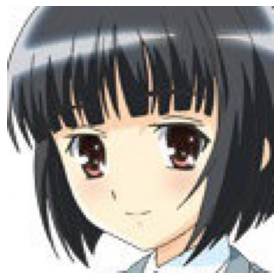

In [7]:
plt.imshow(np.asarray(img))
plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
def get_numpy_images():
    X = []
    for filename in images:
        im = Image.open(os.path.join(images_path, filename)).resize((image_size, image_size))
        im_array = (np.asarray(im, dtype=np.float32) - 127.5) / 127.5 
        im.close()
        X.append(im_array)
    return np.array(X)

In [9]:
X = get_numpy_images()

In [10]:
def plot_images(images, ep):
    assert len(images) == 9, 'Images != 9'
    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i] + 1) / 2)
        plt.tight_layout()
        plt.axis('off')
    # plt.savefig(f'drive/MyDrive/im_{ep}.png')
    plt.show()

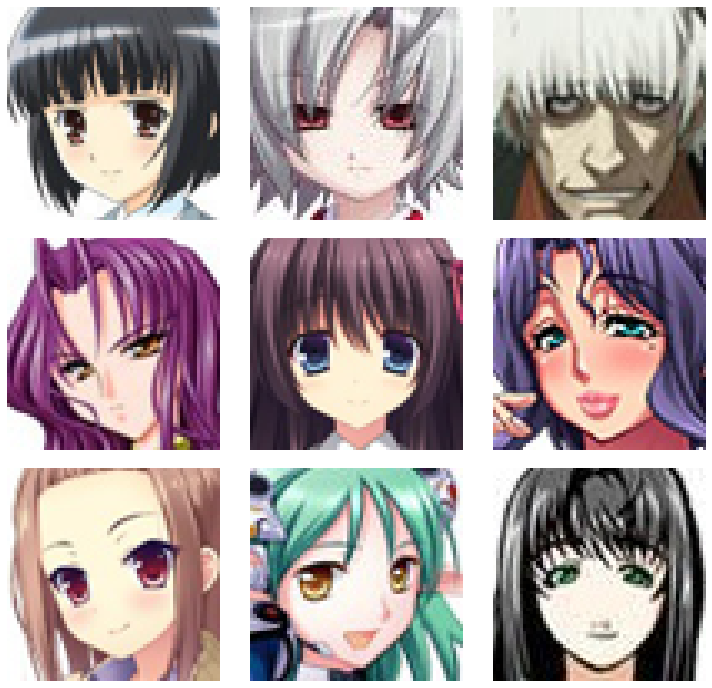

In [11]:
plot_images(X[:9], -1)

In [12]:
def get_discriminator():
    image_input = Input((image_size, image_size, 3))
    
    # 32
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(image_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    # x = MaxPooling2D()(x)
    
    # 16
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    # x = MaxPooling2D()(x)

    # 8
    x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    # x = MaxPooling2D()(x)

    # # 4
    # x = Conv2D(256, (3, 3), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU(alpha=0.15)(x)
    # x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    # x = Dense(32)(x)
    # x = Dropout(0.2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(1, activation='sigmoid')(x)

    model = Model(image_input, x, name='Discriminator')
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


def get_generator():
    input_noise = Input(latent_dims)

    # x = Dense(32)(input_noise)
    # x = Dropout(0.3)(x)
    # x = BatchNormalization()(x)
    # x = LeakyReLU(alpha=0.3)(x)

    # 8
    x = Dense(8 * 8 * 256)(input_noise)
    # x = BatchNormalization()(x)
    # x = Dropout(0.2)(x)
    x = Reshape((8, 8, 256))(x)

    # 16
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    # x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 32
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    # x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 64
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
    # x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 64
    x = Conv2D(3, (3, 3), padding='same', activation='tanh')(x)

    model = Model(input_noise, x, name='Generator')
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


def get_gan():
    # with strategy.scope():
    generator = get_generator()
    discriminator = get_discriminator()

    # generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    # discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    discriminator.trainable = False
    gan = Sequential(name='Gan')
    gan.add(generator)
    gan.add(discriminator)
    # gan = Model(generator, discriminator, name='Gan')
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    return generator, discriminator, gan

In [13]:
def load_models():
    with open('generator.pkl', 'rb') as f:
        generator = pickle.load(f)
    with open('discriminator.pkl', 'rb') as f:
        discriminator = pickle.load(f)
    with open('gan.pkl', 'rb') as f:
        gan = pickle.load(f)
    # discriminator = load_model('discriminator.h5')
    # gan = load_model('gan.h5')
    return generator, discriminator, gan

In [19]:
!unzip -q drive-download-20220108T122405Z-001.zip

In [14]:
# discriminator = get_discriminator()
# generator = get_generator()

# generator, discriminator, gan = get_gan()
generator, discriminator, gan = load_models()

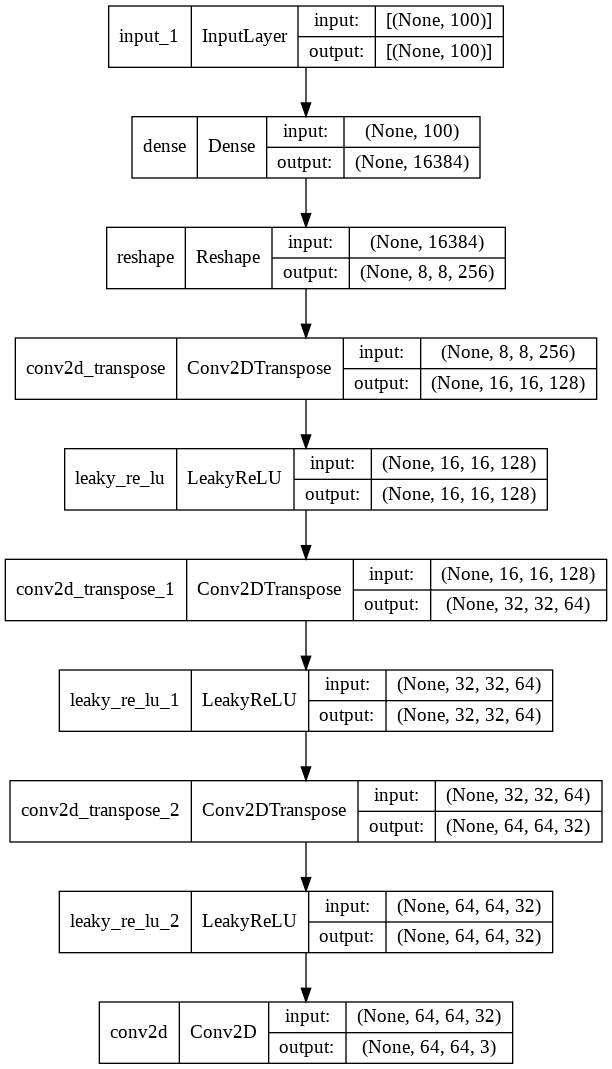

In [15]:
plot_model(generator, to_file='generator.png', show_shapes=True)

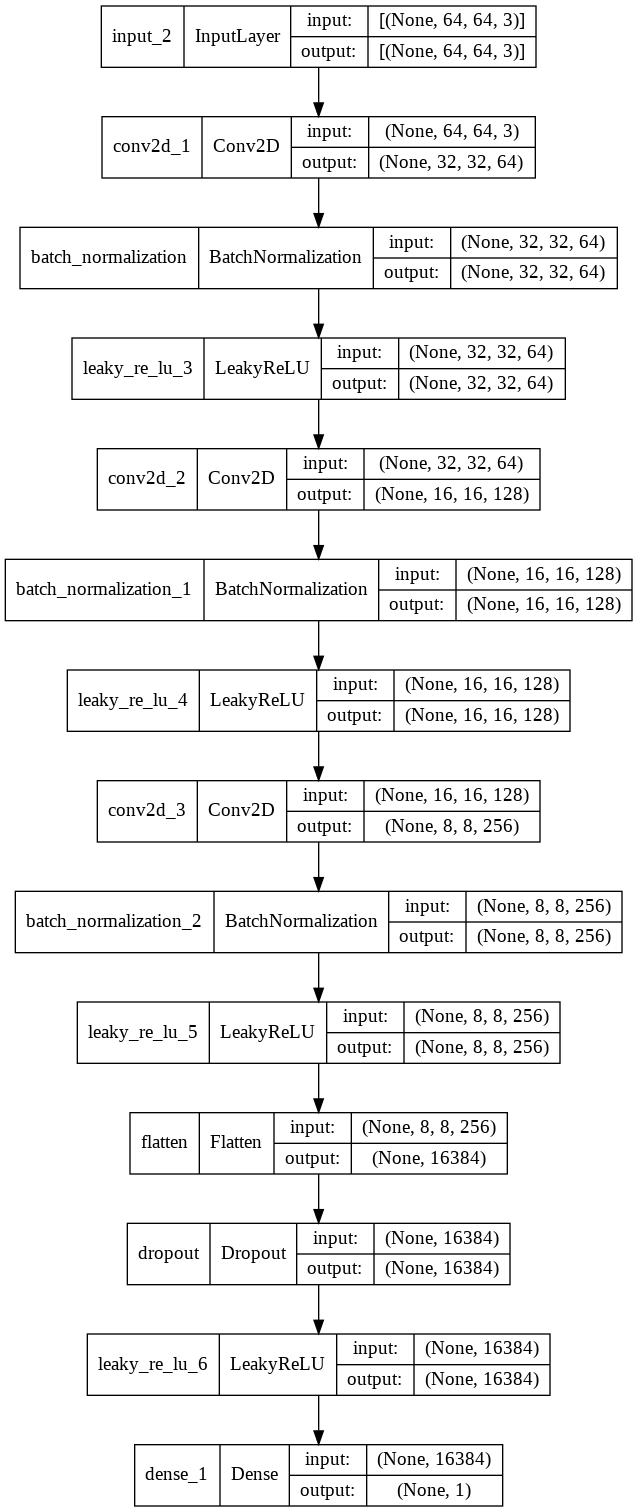

In [16]:
plot_model(discriminator, to_file='discriminator.png', show_shapes=True)

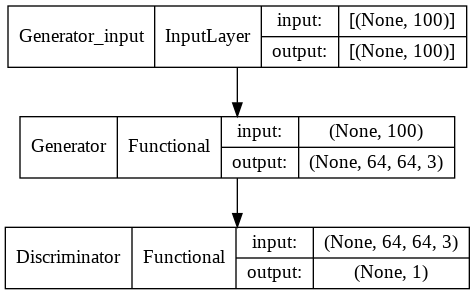

In [17]:
plot_model(gan, to_file='gan.png', show_shapes=True)

In [18]:
gan.summary()

Model: "Gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Functional)      (None, 64, 64, 3)         2042947   
                                                                 
 Discriminator (Functional)  (None, 1)                 388993    
                                                                 
Total params: 2,431,940
Trainable params: 2,042,947
Non-trainable params: 388,993
_________________________________________________________________


In [19]:
np.random.seed(1000)
noise_to_plot = np.random.normal(0, 1, (9, latent_dims))

In [20]:
noise_to_plot = np.load('noise.npy')

In [21]:
discriminator_loss = []
gan_loss = []
result_images = {}

def train_gan(train_data, epochs, batch_size):
    num_batches = train_data.shape[0] // batch_size
    for epoch in range(1, epochs + 1):
        for batch in range(num_batches):
            noise = np.random.normal(0, 1, (batch_size, latent_dims))

            real_images = train_data[np.random.randint(0, train_data.shape[0], batch_size)]
            # print(real_images)
            generated_images = generator.predict(noise)

            X = np.concatenate((generated_images, real_images))
            Y = np.zeros(batch_size * 2)
            Y[batch_size:] = 0.9

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, Y)
            discriminator_loss.append(d_loss)

            discriminator.trainable = False

            noise = np.random.normal(0, 1, (batch_size, latent_dims))
            Y = np.ones(batch_size)

            g_loss = gan.train_on_batch(noise, Y)
            gan_loss.append(g_loss)

        if epoch % 2 == 0 and epoch != 0:
            # generator.save('generator.h5')
            # discriminator.save('discriminator.h5')
            # gan.save('gan.h5')
            with open('generator.pkl', 'wb') as f:
                pickle.dump(generator, f)
            with open('discriminator.pkl', 'wb') as f:
                pickle.dump(discriminator, f)
            with open('gan.pkl', 'wb') as f:
                pickle.dump(gan, f)

        result = generator.predict(noise_to_plot)
        print(f'Epoch: {epoch}')
        plot_images(result, epoch)
        result_images[epoch] = result

In [ ]:
train_gan(X, epochs, batch_size)

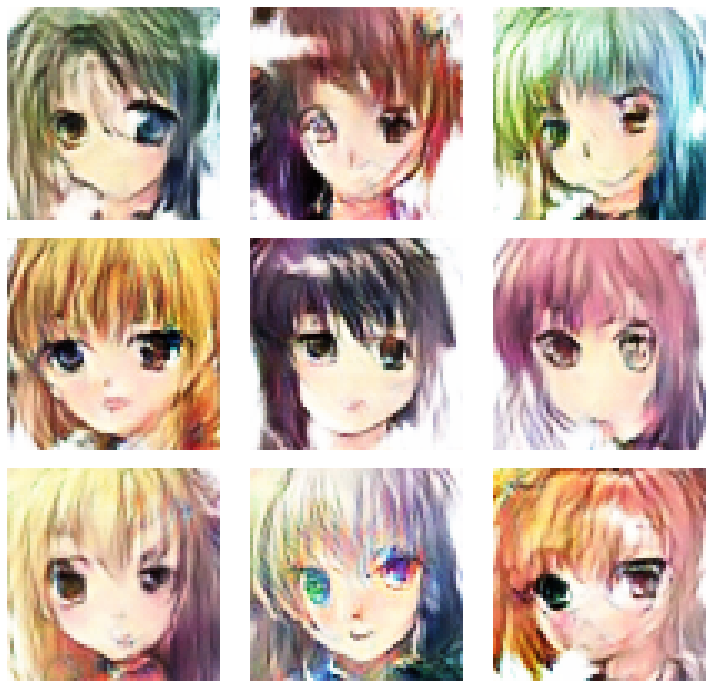

In [27]:
pr = generator.predict(np.random.normal(0, 1, (9, latent_dims)))
plot_images(pr, 'test')